In [1]:
from pathlib import Path
import sys
import torch
import albumentations as A
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader as TorchDataLoader
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import tqdm.auto as tqdm
import json
import cv2

import os
import time
import glob

%matplotlib inline

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
annotations = {}
anno_paths = glob.glob('../scale_annotation/results/*.json')
for anno_path in anno_paths:
    with open(anno_path,'r') as f:
        annos = json.load(f)
        for anno in tqdm.tqdm(annos):
            keypoint_names = anno['params']['geometries']['point']['objects_to_annotate']
            img_name = anno['metadata']['filename']
            img_path = f'../scale_annotation/images/{img_name.split(".")[0]}/{img_name}'
            uvs = np.zeros((len(keypoint_names),2))*np.nan
            for pt in anno['response']['annotations']:
                ix = keypoint_names.index(pt['label'])
                uvs[ix,0] = pt['x']
                uvs[ix,1] = pt['y']
            annotations[img_path] = uvs

100%|██████████| 3000/3000 [00:00<00:00, 51677.33it/s]


In [3]:
keypoint_names

['tail_tip',
 'tail_base',
 'spine_low',
 'spine_mid',
 'spine_high',
 'left_ear',
 'right_ear',
 'forehead',
 'nose_tip',
 'left_hind_paw_front',
 'left_hind_paw_back',
 'right_hind_paw_front',
 'right_hind_paw_back',
 'left_fore_paw',
 'right_fore_paw']

In [3]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr

def get_grid(W, H, num_keypoints, downsample=4):
    grid = cartesian_product(np.arange(0, W, downsample, dtype=np.float32),
                             np.arange(0, H, downsample, dtype=np.float32))
    grid = np.repeat(grid[None], num_keypoints, axis=0)
    return grid

def uv_to_heatmap(uv, grid, sigma):
    vu = np.copy(np.flip(uv, axis=-1))
    isnan = np.isnan(vu[:, 0])
    vu[isnan] = 0
    y = np.exp(-np.sum((grid - vu[:,None,None,:]) ** 2, axis=-1) / sigma)
    y[isnan] = 0
    return y


class DataLoader(Dataset):
    def __init__(self, annotations, augment=True, stride=16, sigma=40):
        self.annotations = annotations
        self.image_paths = sorted(self.annotations.keys())
        self.grid = get_grid(1024//2, 1280//2, 1, downsample=stride)
        self.sigma = sigma

        if augment:
            self.transform = A.Compose(
                [
                    A.ShiftScaleRotate(p=0.8, scale_limit=0.2, rotate_limit=25, border_mode=1),
                    A.GaussNoise(p=0.25),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                ], 
                keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        else:
            self.transform = None

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        keypoints = self.annotations[img_path]/2
        keypoints_mask = np.isnan(keypoints).any(1)
        keypoints = np.nan_to_num(keypoints)
        image = cv2.imread(img_path)[::2,::2]
        
        if image.shape[0] < 512: 
            padding = np.zeros((512-image.shape[0],image.shape[1],3), dtype=np.uint8)
            image = np.vstack((image, padding))

        if not self.transform is None:
            transformed = self.transform(image=image, keypoints=keypoints)
            image = transformed['image']
            keypoints = np.array(transformed['keypoints'])
        
        keypoints[keypoints_mask] = np.nan
        centroid = np.nanmedian(keypoints,axis=0)
        heatmap = uv_to_heatmap(centroid[None], self.grid, sigma=self.sigma**2)

        image = torch.tensor(image[None,:,:,0].astype(np.float32))/255
        heatmap = torch.tensor(heatmap.astype(np.float32))
        return image, heatmap

In [4]:
import glob
train_annotations = {}
test_annotations = {}

np.random.seed(0)
for k in sorted(annotations):
    if np.random.uniform() < .1:
        test_annotations[k] = annotations[k]
    else:
        train_annotations[k] = annotations[k]
        
train_loader = TorchDataLoader(DataLoader(train_annotations), batch_size=8, shuffle=True)
test_loader = TorchDataLoader(DataLoader(test_annotations, augment=False), batch_size=8, shuffle=True)

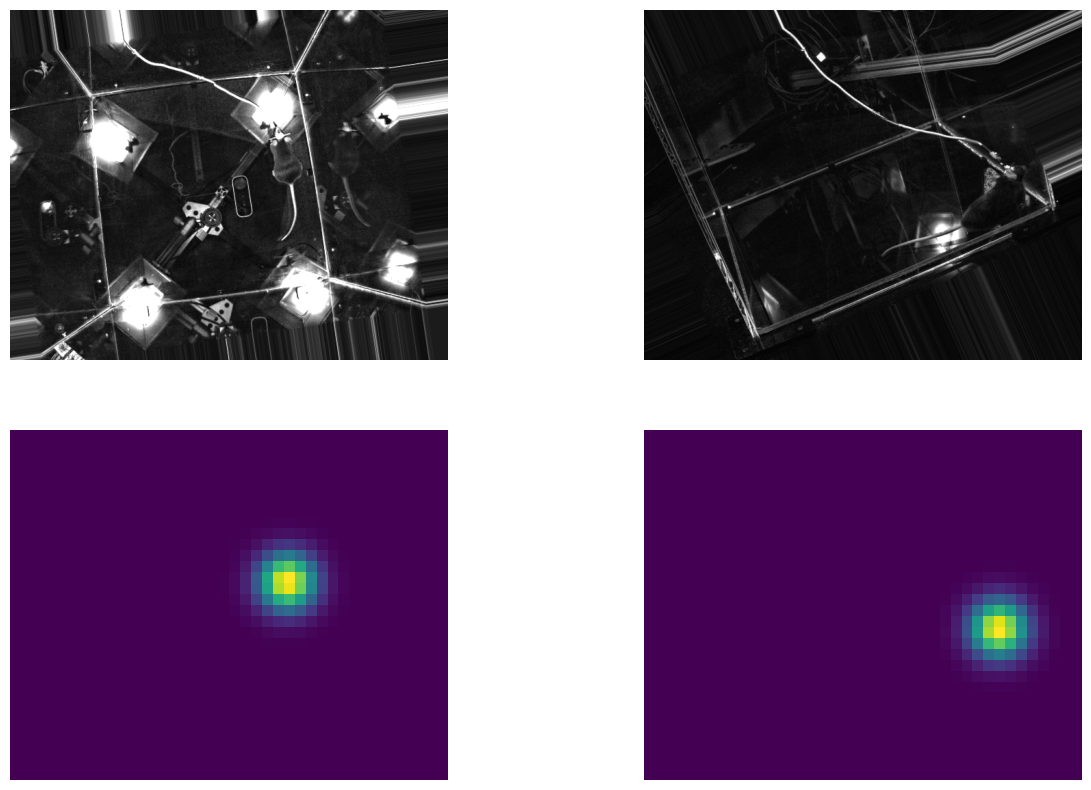

In [5]:
img,hm = next(iter(train_loader))
fig,axs = plt.subplots(2,2)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray)
    axs[1,i].imshow(hm[i].max(0)[0])
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,10))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, initial_channels=32):
        super(ConvNet, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, initial_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(initial_channels)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(initial_channels, initial_channels*2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(initial_channels*2)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(initial_channels*2, initial_channels*4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(initial_channels*4)
        
        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(initial_channels*4, initial_channels*4, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(initial_channels*4)
        
        # MaxPooling Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Final Convolutional Layer to generate 1-channel output
        self.conv_final = nn.Conv2d(initial_channels*4, 1, kernel_size=1, stride=1)
        
    def forward(self, x):
        # First Conv + ReLU + MaxPool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # Second Conv + ReLU + MaxPool
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # Third Conv + ReLU + MaxPool
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # Fourth Conv + ReLU + MaxPool
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # Final Conv
        x = self.conv_final(x)
        x = F.sigmoid(x)
        return x


model = ConvNet(initial_channels=32)
model.to('cuda')

checkpoint_dir = 'custom_checkpoints'
if not os.path.exists(checkpoint_dir) or len(os.listdir(checkpoint_dir))==0:
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0
else:
    file_names = os.listdir(checkpoint_dir)
    max_epoch = max([int(f[len(pretrain_dataset) + 1: -4]) for f in file_names])
    start_path = os.path.join(checkpoint_dir, f'custom_{max_epoch}.pth')
    start_epoch = max_epoch + 1
    weights = torch.load(start_path)
    model.load_state_dict(weights)


In [8]:
model = ConvNet(initial_channels=32)
weights = torch.load('weights/centernet.pth')
model.load_state_dict(weights)
model = model.eval().to('cuda')


In [27]:
#history = []
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3/4)
model = model.eval()
for epoch in range(start_epoch, 300):
    train_losses = []
    for x, y in tqdm.tqdm(train_loader):
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x)
        loss = mse(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        del x, y, y_pred

    # save at the end of each epoch
    save_path = os.path.join(checkpoint_dir, f'custom_{epoch}.pth')
    torch.save(model.state_dict(), save_path)
    
    test_losses = []
    for x, y in tqdm.tqdm(test_loader):
        with torch.no_grad():
            x = x.to('cuda')
            y = y.to('cuda')  
            y_pred = model(x)
            test_losses.append(mse(y_pred, y).item())
            del x, y, y_pred
            
    print(epoch, np.mean(train_losses), np.mean(test_losses))
    history.append((epoch, np.mean(train_losses), np.mean(test_losses)))


100%|██████████| 70/70 [00:11<00:00,  5.96it/s]


0 0.0017341019652566464 0.0017837293629002359


100%|██████████| 70/70 [00:11<00:00,  5.86it/s]


1 0.0017195278237910195 0.0017827301427522407


100%|██████████| 70/70 [00:12<00:00,  5.56it/s]


2 0.001723860659029141 0.0017671812824638826


100%|██████████| 70/70 [00:12<00:00,  5.72it/s]


3 0.0017076000567211268 0.0018243703874759377


100%|██████████| 70/70 [00:11<00:00,  5.96it/s]


4 0.0017218060810038122 0.0017789050437776106


100%|██████████| 70/70 [00:12<00:00,  5.69it/s]


5 0.0016955356177879785 0.0017756431529830608


100%|██████████| 70/70 [00:12<00:00,  5.68it/s]


6 0.0016855883062449916 0.0017734040190199656


100%|██████████| 70/70 [00:12<00:00,  5.82it/s]


7 0.0017013310049719262 0.0017752893884400171


100%|██████████| 70/70 [00:12<00:00,  5.81it/s]


8 0.0017066186621538379 0.0017578541234667812


100%|██████████| 70/70 [00:12<00:00,  5.81it/s]


9 0.001697585245407824 0.001793170568998903


100%|██████████| 70/70 [00:12<00:00,  5.51it/s]


10 0.001694779618891479 0.0017564039028781866


100%|██████████| 70/70 [00:11<00:00,  5.93it/s]


11 0.0016958188749952624 0.0017853210547140667


100%|██████████| 70/70 [00:11<00:00,  6.02it/s]


12 0.001686439382489653 0.0017815053230151533


100%|██████████| 70/70 [00:11<00:00,  6.01it/s]


13 0.0016872895438457642 0.0017558432092690574


100%|██████████| 70/70 [00:11<00:00,  6.03it/s]


14 0.0016922931909768282 0.00174327962366598


100%|██████████| 70/70 [00:11<00:00,  6.05it/s]


15 0.0016912165328703103 0.0017936527263373136


100%|██████████| 70/70 [00:11<00:00,  6.06it/s]


16 0.001688682190502468 0.0017940184068200844


100%|██████████| 70/70 [00:11<00:00,  6.06it/s]


17 0.0016877739410223116 0.0018074057846596198


100%|██████████| 70/70 [00:11<00:00,  6.04it/s]


18 0.0016795257746340408 0.001761707738374493


100%|██████████| 70/70 [00:11<00:00,  6.02it/s]


19 0.0016763434634831872 0.0017236804739306016


100%|██████████| 70/70 [00:11<00:00,  5.99it/s]


20 0.0016793651254377578 0.0017504628847486207


100%|██████████| 70/70 [00:12<00:00,  5.58it/s]


21 0.0016793205837237323 0.0017542719134196107


100%|██████████| 70/70 [00:11<00:00,  5.93it/s]


22 0.001675836917740801 0.0017658355978450605


100%|██████████| 70/70 [00:11<00:00,  5.96it/s]


23 0.0016851203943226687 0.001741031717808385


100%|██████████| 70/70 [00:12<00:00,  5.75it/s]


24 0.0016855504843024448 0.0017301061623064536


100%|██████████| 70/70 [00:12<00:00,  5.71it/s]


25 0.001680764788321046 0.0017544411555198687


100%|██████████| 70/70 [00:11<00:00,  5.87it/s]


26 0.0016710509745145588 0.0017320055248481886


100%|██████████| 70/70 [00:11<00:00,  6.03it/s]


27 0.0016728746292529457 0.0017507479792194707


  6%|▌         | 35/634 [00:10<02:52,  3.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 70/70 [00:12<00:00,  5.79it/s]


38 0.0016605343461427427 0.0017744238937406668


100%|██████████| 70/70 [00:11<00:00,  5.93it/s]


39 0.0016606741137538187 0.0017358650303711848


100%|██████████| 70/70 [00:12<00:00,  5.66it/s]


40 0.0016694750241297723 0.001759945779174034


 73%|███████▎  | 464/634 [02:29<00:54,  3.11it/s]


KeyboardInterrupt: 

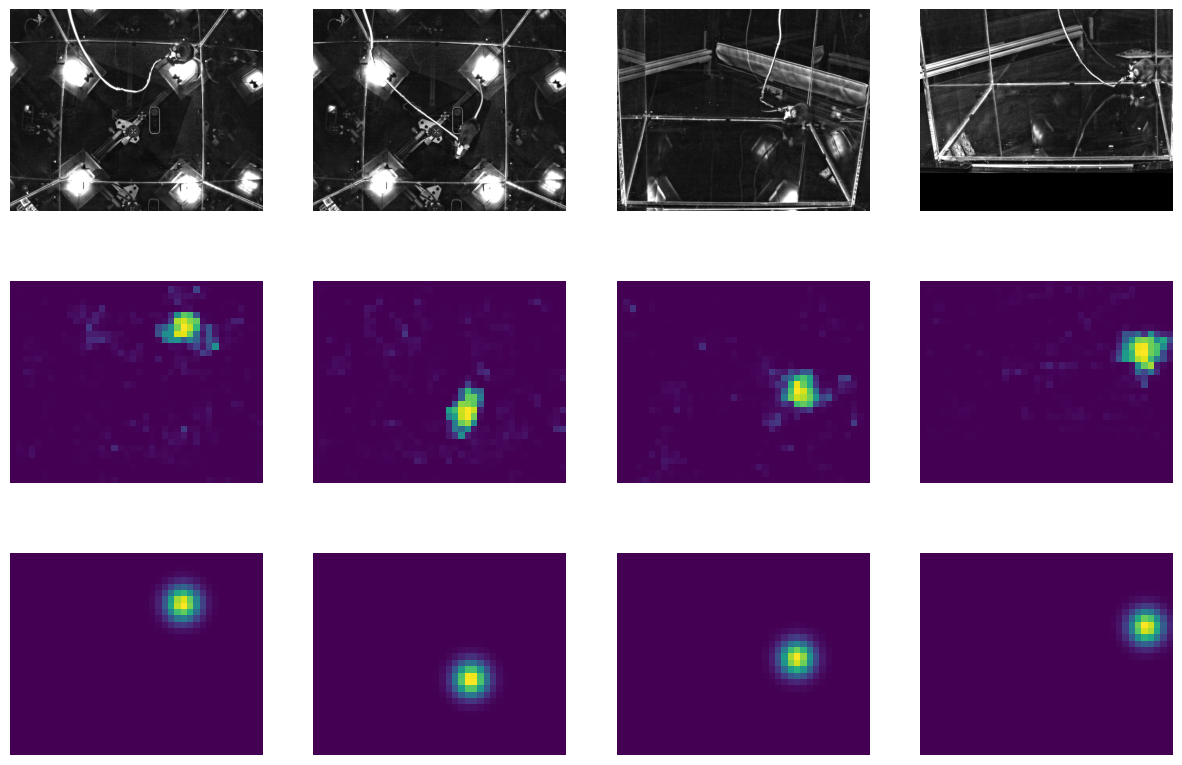

In [9]:
img,hm = next(iter(test_loader))
y = model(img.to('cuda')).detach().cpu().numpy()
img = img.numpy()
hm = hm.numpy()
fig,axs = plt.subplots(3,4)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray)
    axs[1,i].imshow(y[i].max(0))
    axs[2,i].imshow(hm[i].max(0))
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,10))

In [17]:
vid_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01704/20230822_J01704_b/bottom.24562650.avi'
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))
from vidio.read import OpenCVReader
reader = OpenCVReader(vid_path)
nframes = len(reader)

for i in tqdm.trange(nframes):
    with torch.no_grad():
        im = clahe.apply(reader[i][:,:,0])
        x = im[None,None].astype(np.float32)/255
        y = model(torch.Tensor(x).to('cuda')[:,:,::2,::2])


  0%|          | 111/216000 [00:01<1:00:25, 59.54it/s]


KeyboardInterrupt: 

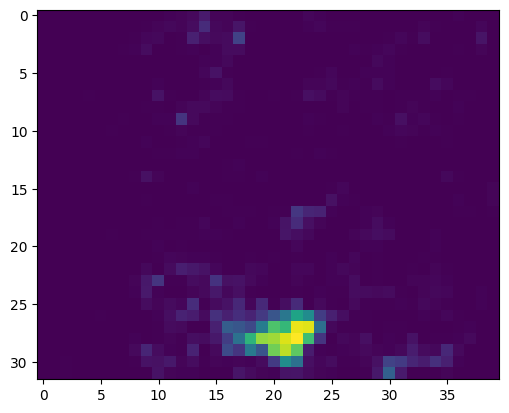

In [18]:
plt.imshow(y.detach().cpu()[0,0])

(8, 1, 512, 640)